# Importing Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


---

# Color

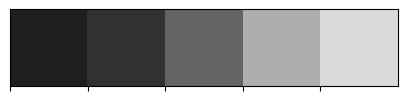

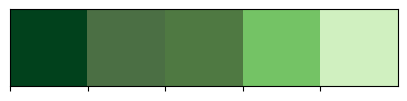

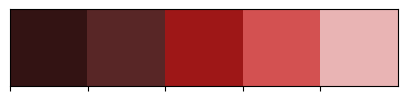

In [2]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

---

# Data Preperation

In [3]:
labels = ['NORMAL','PNEUMONIA']

In [4]:
X_train = []
y_train = []
image_size = 128
for i in labels:
    folderPath = os.path.join('/kaggle/input/labeled-chest-xray-images/chest_xray','test',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('/kaggle/input/labeled-chest-xray-images/chest_xray','train',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 3883/3883 [01:13<00:00, 52.73it/s]


We start off by appending all the images from the  directories into a Python list and then converting them into numpy arrays after resizing it.

/tmp/ipykernel_48/986177961.py:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if y_train[j]==i:


IndexError: index 5270 is out of bounds for axis 0 with size 5270

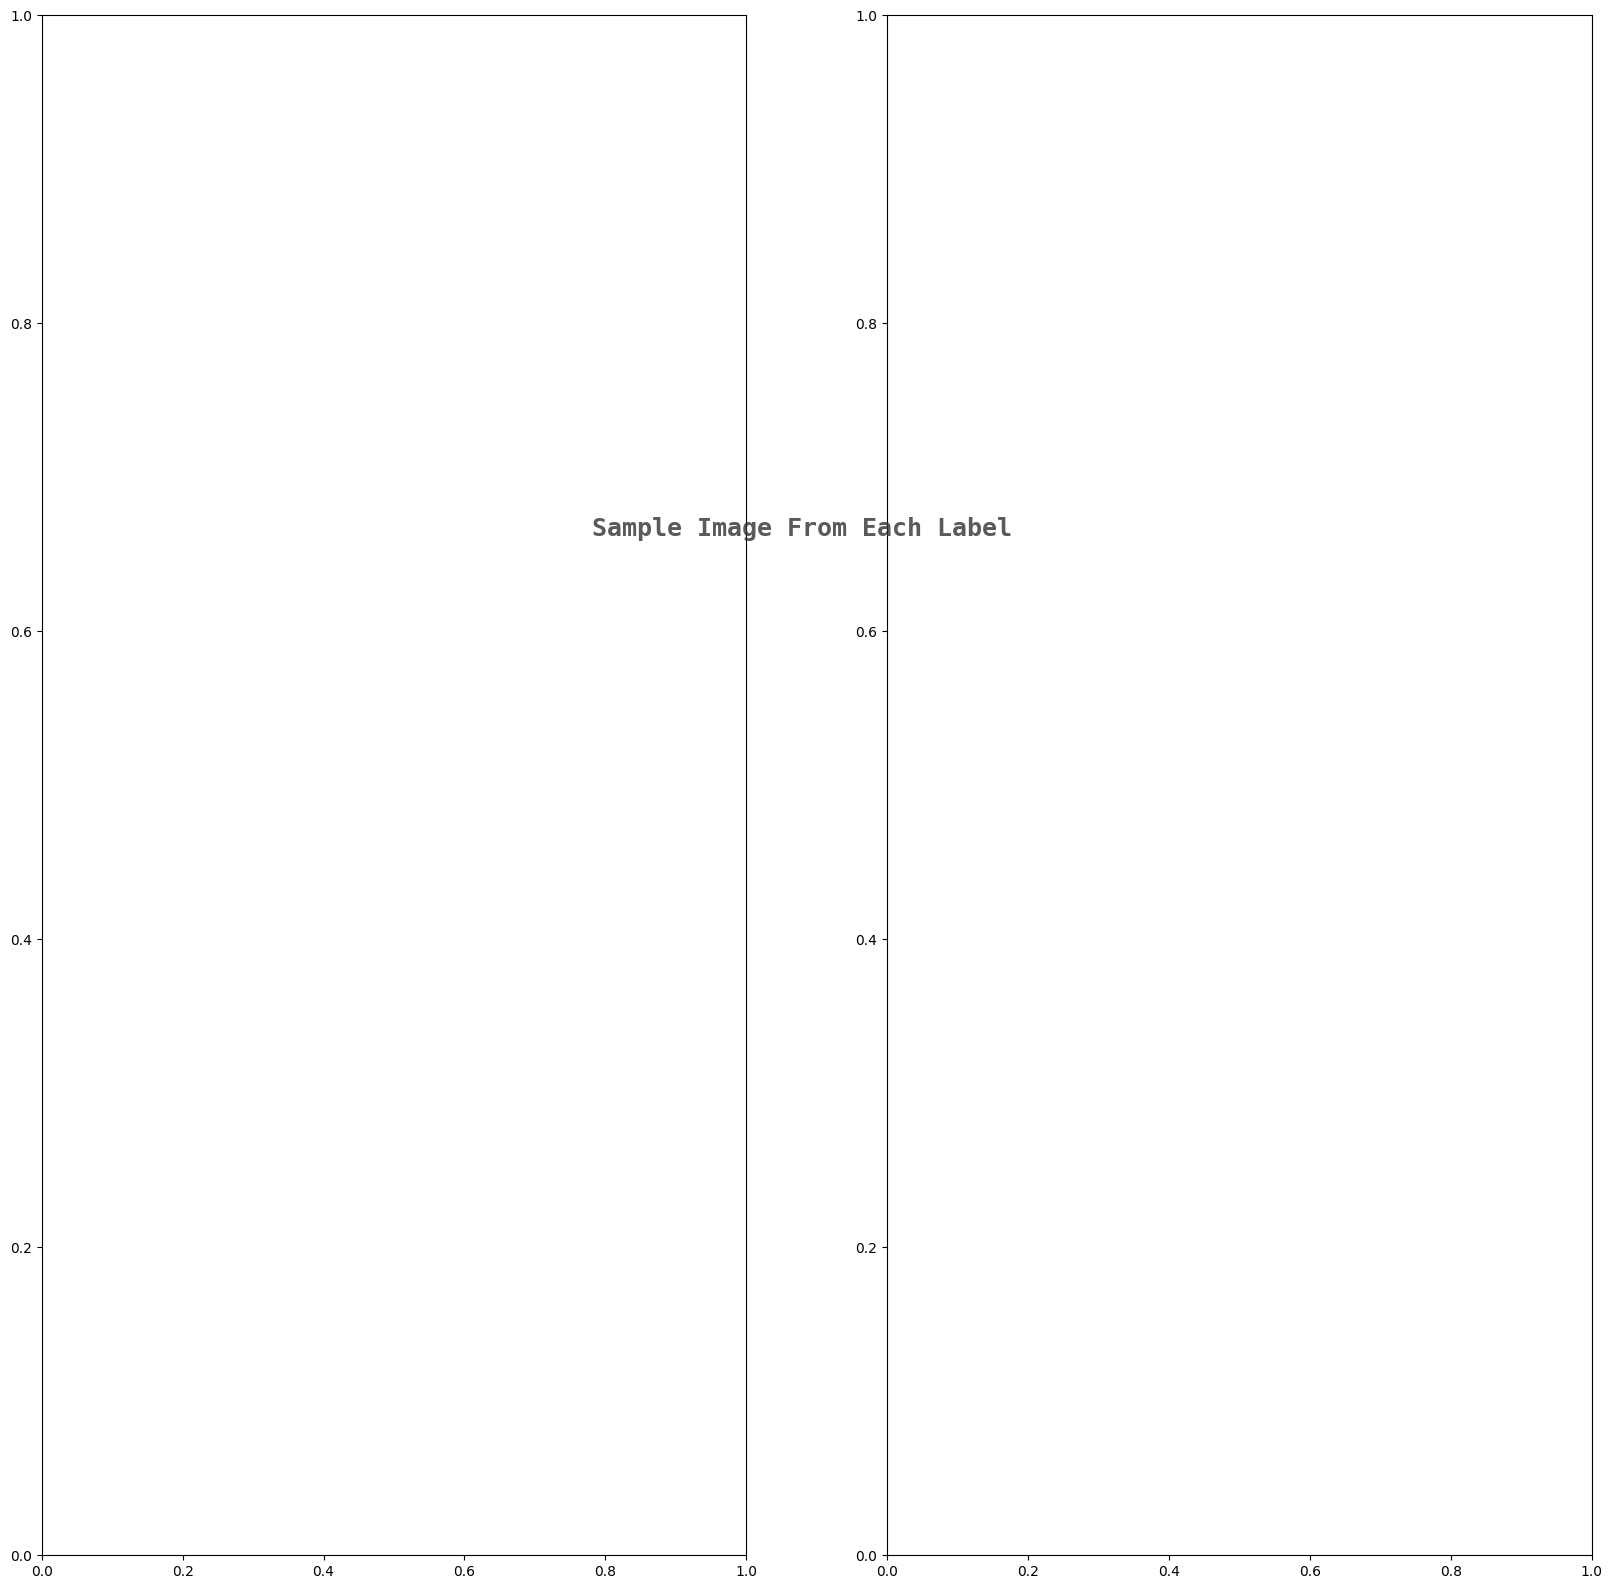

In [40]:
k=0
fig, ax = plt.subplots(1,2,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [6]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [7]:
X_train.shape

(5856, 128, 128, 3)

**Image Data Augmentation**: Image data augmentation is a technique that can be used to artificially expand the size of a training dataset by creating modified versions of images in the dataset. It uses techniques such as flipping, zooming, padding, cropping, etc.<br><br>
Data augmentation makes the model more robust to slight variations, and hence *prevents the model from overfitting.*
<br><br>
To do so using Keras, we use the function **ImageDataGenerator** 

In [8]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)

datagen.fit(X_train)
X_train.shape

(5856, 128, 128, 3)

Dividing the dataset into **Training** and **Testing** sets.

In [9]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [10]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

---

# Transfer Learning

Deep convolutional neural network models may take days or even weeks to train on very large datasets.

A way to short-cut this process is to re-use the model weights from pre-trained models that were developed for standard computer vision benchmark datasets, such as the ImageNet image recognition tasks. Top performing models can be downloaded and used directly, or integrated into a new model for your own computer vision problems.

In this notebook, I'll be using the **EfficientNetB0** model which will use the weights from the **ImageNet** dataset.

The include_top parameter is set to *False* so that the network doesn't include the top layer/ output layer from the pre-built model which allows us to add our own output layer depending upon our use case!

In [11]:

from tensorflow.keras.applications import ResNet152V2
resnet = ResNet152V2(weights='imagenet', include_top=False,input_shape=(image_size,image_size,3))

234545216/234545216 [==============================] - 8s 0us/step


In [12]:
#effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

**GlobalAveragePooling2D** -> This layer acts similar to the Max Pooling layer in CNNs, the only difference being is that it uses the Average values instead of the Max value while *pooling*. This really helps in decreasing the computational load on the machine while training.
<br><br>
**Dropout** -> This layer omits some of the neurons at each step from the layer making the neurons more independent from the neibouring neurons. It helps in avoiding overfitting. Neurons to be ommitted are selected at random. The **rate** parameter is the liklihood of a neuron activation being set to 0, thus dropping out the neuron

**Dense** -> This is the output layer which classifies the image into 1 of the 4 possible classes. It uses the **softmax** function which is a generalization of the sigmoid function.

In [13]:
model = resnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(2,activation='softmax')(model)
model = tf.keras.models.Model(inputs=resnet.input, outputs = model)

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 66, 66, 64)           0         ['conv1_conv[0][0]']          
                                                                                              

We finally compile our model.

In [15]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

**Callbacks** -> Callbacks can help you fix bugs more quickly, and can help you build better models. They can help you visualize how your model’s training is going, and can even help prevent overfitting by implementing early stopping or customizing the learning rate on each iteration.<br><br>
By definition, "A callback is a set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training."

In this notebook, I'll be using **TensorBoard, ModelCheckpoint and ReduceLROnPlateau** callback functions

In [16]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("resnet152v1.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.4, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

---

# Training The Model

In [17]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =10, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/10
149/149 [==============================] - ETA: 0s - loss: 0.1839 - accuracy: 0.9283
Epoch 1: val_accuracy improved from -inf to 0.71917, saving model to resnet152v1.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


149/149 [==============================] - 133s 224ms/step - loss: 0.1839 - accuracy: 0.9283 - val_loss: 8.0931 - val_accuracy: 0.7192 - lr: 0.0010
Epoch 2/10
149/149 [==============================] - ETA: 0s - loss: 0.1121 - accuracy: 0.9597
Epoch 2: val_accuracy did not improve from 0.71917
149/149 [==============================] - 26s 178ms/step - loss: 0.1121 - accuracy: 0.9597 - val_loss: 3.3452 - val_accuracy: 0.7135 - lr: 0.0010
Epoch 3/10
149/149 [==============================] - ETA: 0s - loss: 0.0839 - accuracy: 0.9705
Epoch 3: val_accuracy improved from 0.71917 to 0.90323, saving model to resnet152v1.h5
149/149 [==============================] - 29s 197ms/step - loss: 0.0839 - accuracy: 0.9705 - val_loss: 0.3167 - val_accuracy: 0.9032 - lr: 0.0010
Epoch 4/10
149/149 [==============================] - ETA: 0s - loss: 0.0623 - accuracy: 0.9774
Epoch 4: val_accuracy improved from 0.90323 to 0.90512, saving model to resnet152v1.h5
149/149 [==============================] - 29

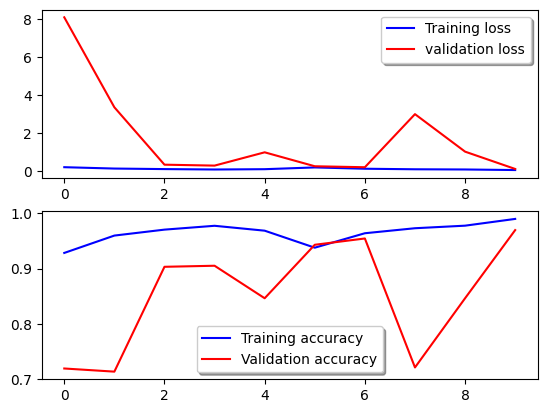

In [18]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [21]:
train_dir = "/kaggle/input/labeled-chest-xray-images/chest_xray/train"
test_dir = "/kaggle/input/labeled-chest-xray-images/chest_xray/test"

In [22]:
import tensorflow as tf

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 image_size=(128,128),
                                                                 label_mode = "categorical",
                                                                 batch_size = 32
                                                                 )
test_data =tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               image_size =(128,128),
                                                               label_mode = "categorical",
                                                               batch_size = 32
                                                               )

Found 5232 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


# Evaluation

In [23]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

19/19 [==============================] - 4s 81ms/step


In [24]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.99      0.88      0.93       168
           1       0.95      1.00      0.97       418

    accuracy                           0.96       586
   macro avg       0.97      0.94      0.95       586
weighted avg       0.96      0.96      0.96       586



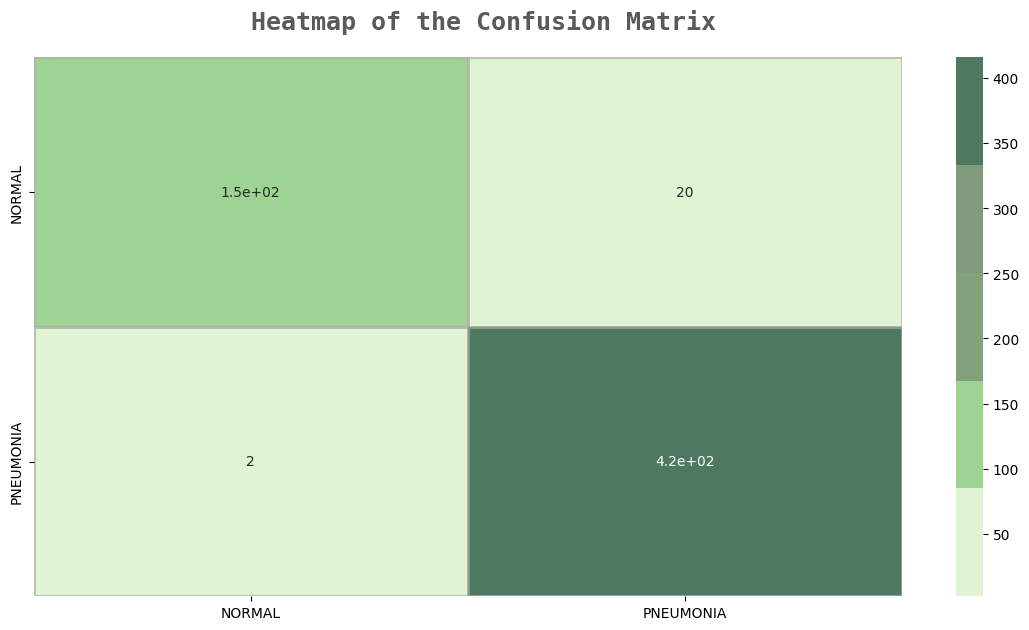

In [25]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

In [38]:
import cv2
import numpy as np
from PIL import Image

def img_pred(file_path):
    img = Image.open(file_path)
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage, (150, 150))
    img = img.reshape(1, 150, 150, 3)
    p = model.predict(img)
    p = np.argmax(p, axis=1)[0]

    if p == 0:
        p = 'NORMAL'
    else:
        p = 'PNEUMONIA'

    return f'The Model predicts that it is a {p}'

result = img_pred('/kaggle/input/labeled-chest-xray-images/chest_xray/test/NORMAL/NORMAL-1110860-0001.jpeg')
print(result)

1/1 [==============================] - 0s 30ms/step
The Model predicts that it is a NORMAL
